# Homework Assignment 7

In [1]:
!pip install kaggle spaCy afinn nltk plotly bertopic transformers catboost
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 2.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from collections import Counter
from afinn import Afinn
from tqdm import tqdm
import networkx as nx
import pandas as pd
import numpy as np
import spacy
import json
import nltk

In [3]:
TEST_RATIO: float = 0.2
nltk.download('stopwords')
nltk.download('punkt')
nlp = spacy.load('en_core_web_lg')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
api_token = {"username":"","key":""}

!mkdir /root/.kaggle

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!mkdir ./datasets
!mkdir ./datasets/michaelrussell4/10000-books-and-their-genres-standardized

!kaggle datasets download michaelrussell4/10000-books-and-their-genres-standardized -p ./datasets/michaelrussell4/10000-books-and-their-genres-standardized
!unzip ./datasets/michaelrussell4/10000-books-and-their-genres-standardized/*.zip  -d ./datasets/michaelrussell4/10000-books-and-their-genres-standardized/

mkdir: cannot create directory ‘./datasets’: File exists
mkdir: cannot create directory ‘./datasets/michaelrussell4/10000-books-and-their-genres-standardized’: File exists
Dataset URL: https://www.kaggle.com/datasets/michaelrussell4/10000-books-and-their-genres-standardized
License(s): CC0-1.0
10000-books-and-their-genres-standardized.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./datasets/michaelrussell4/10000-books-and-their-genres-standardized/10000-books-and-their-genres-standardized.zip
replace ./datasets/michaelrussell4/10000-books-and-their-genres-standardized/books_and_genres.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Question 1:** Select three books and construct networks of people and locations, i.e. each link is between a a person and a location (20pt). Visualize the network using Cytoscape, Gephi, or any other Graph Visualization tool (20pt).


#### Helper Functions

In [9]:
def load_data():
  books_and_genres_df = pd.read_csv("/content/datasets/michaelrussell4/10000-books-and-their-genres-standardized/10000-books-and-their-genres-standardized.zip")
  return [
      list(books_and_genres_df[books_and_genres_df["title"]=="the warriors"]["text"])[0],
      list(books_and_genres_df[books_and_genres_df["title"]=="young folks history"]["text"])[0],
      list(books_and_genres_df[books_and_genres_df["title"]=="the eye of zeitoon"]["text"])[0]
  ]

def get_person_to_location(txt: str):
    doc = nlp(txt)
    ents = [ent.text.lower().strip() for ent in doc.ents if ent.label_ in {"PERSON", "LOC"}]
    persons = {ent.text.lower().strip() for ent in doc.ents if ent.label_ == "PERSON"}

    links_set = {
        (p, l) if p in persons else (l, p)
        for p in ents
        for l in ents
        if p != l and len(p) > 1 and len(l) > 1 and (
            (p in persons and l not in persons) or (l in persons and p not in persons)
        )
    }
    return links_set

def get_people_to_location_graph(txt):
    paragraphs = txt.split("\n\n")
    links = [link for para in tqdm(paragraphs) for link in get_person_to_location(para)]
    counts = Counter(links)

    g = nx.Graph()
    g.add_edges_from([(p1, p2, {"weight": w}) for (p1, p2), w in counts.items()])

    people = {p1 for p1, _ in links}
    node_colors = ['blue' if node in people else 'red' for node in g.nodes()]

    return g, node_colors

def question_1_by_idx(idx: int, book) -> None:
  print(f"Ploting book {idx}:")
  print(f"-------------------")
  g,node_colors=get_people_to_location_graph(book)
  plt.figure(figsize=(15,15))
  nx.draw_kamada_kawai(g, node_color=node_colors, with_labels=True)
  plt.show()


Ploting book 1:


100%|██████████| 585/585 [00:18<00:00, 31.75it/s]


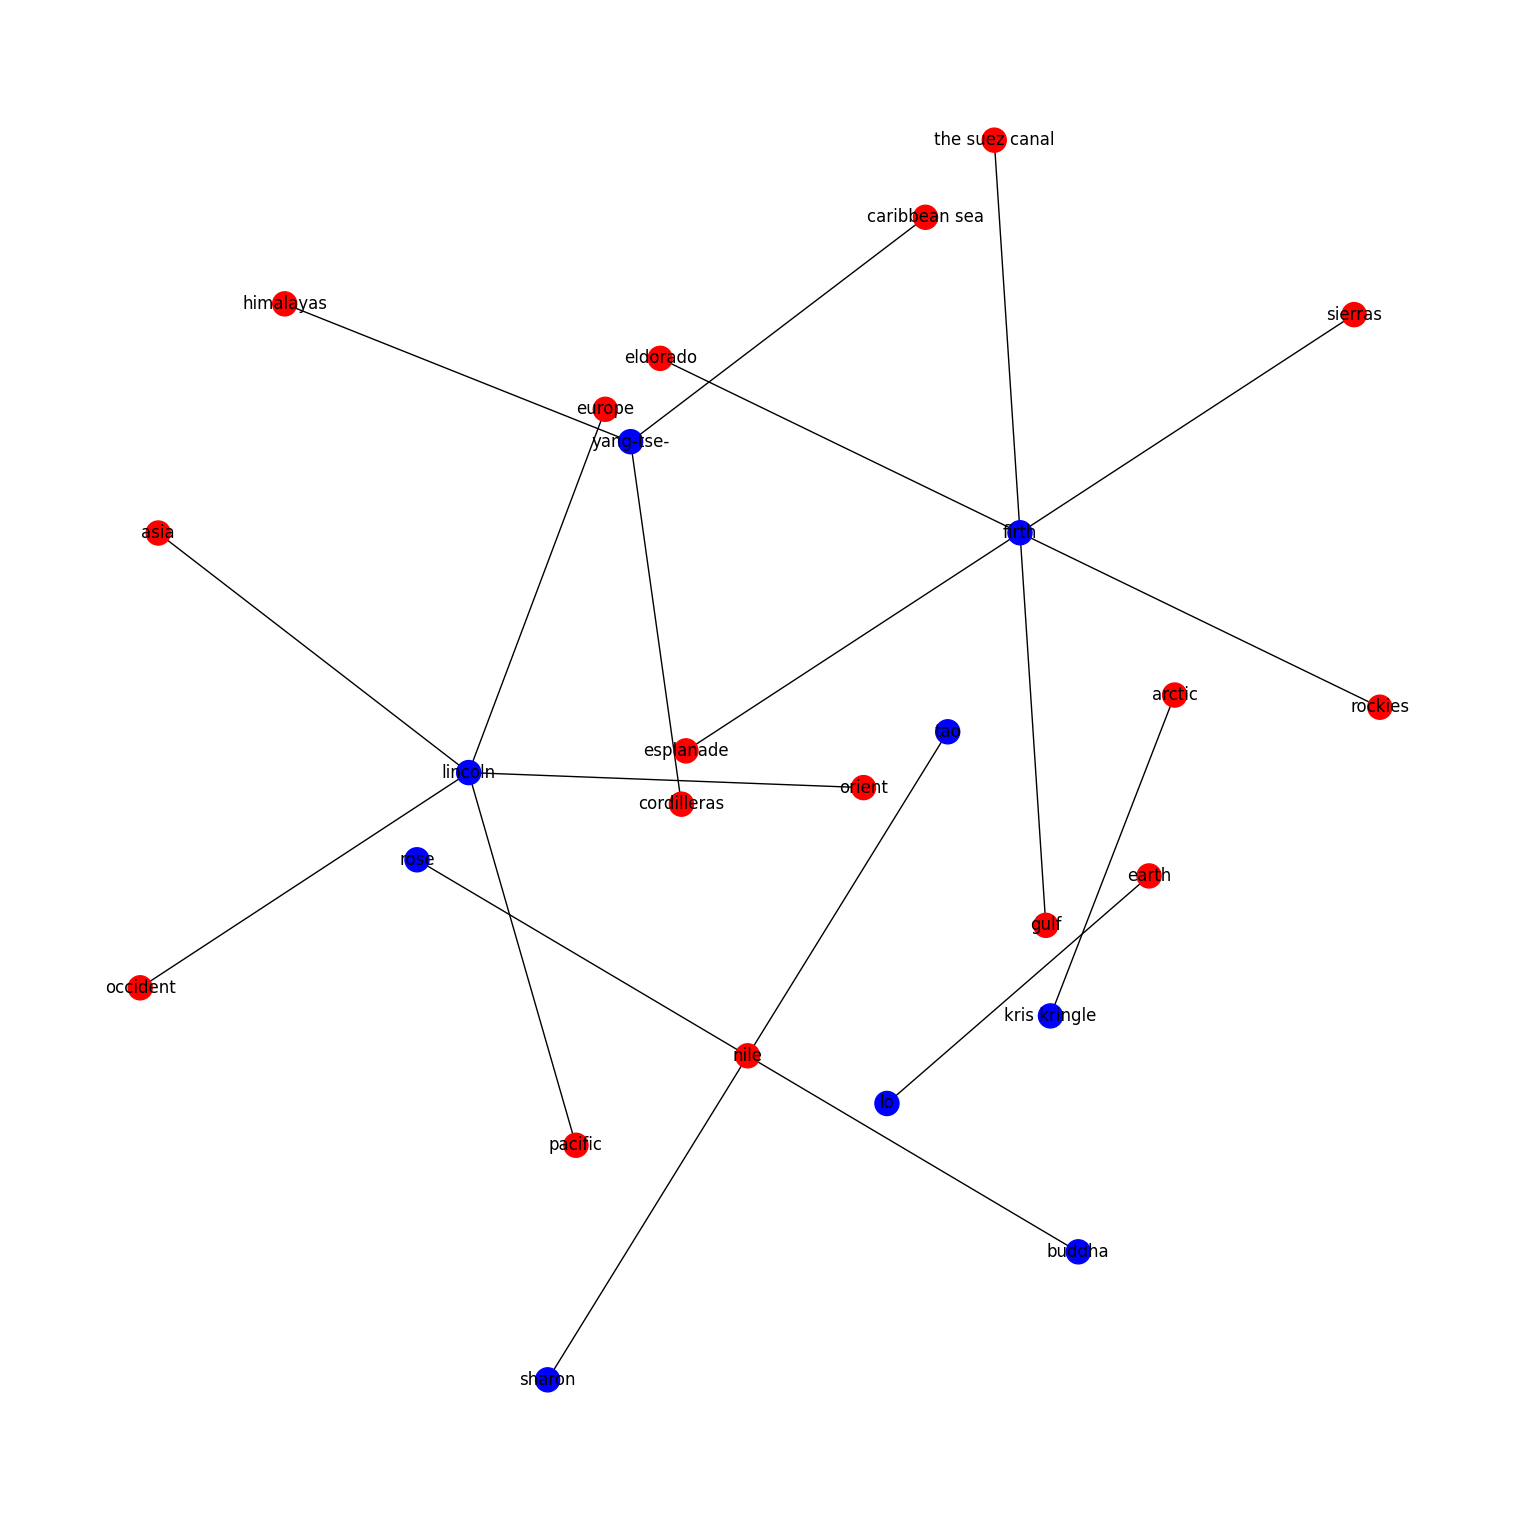

Ploting book 2:


100%|██████████| 567/567 [00:12<00:00, 46.03it/s]


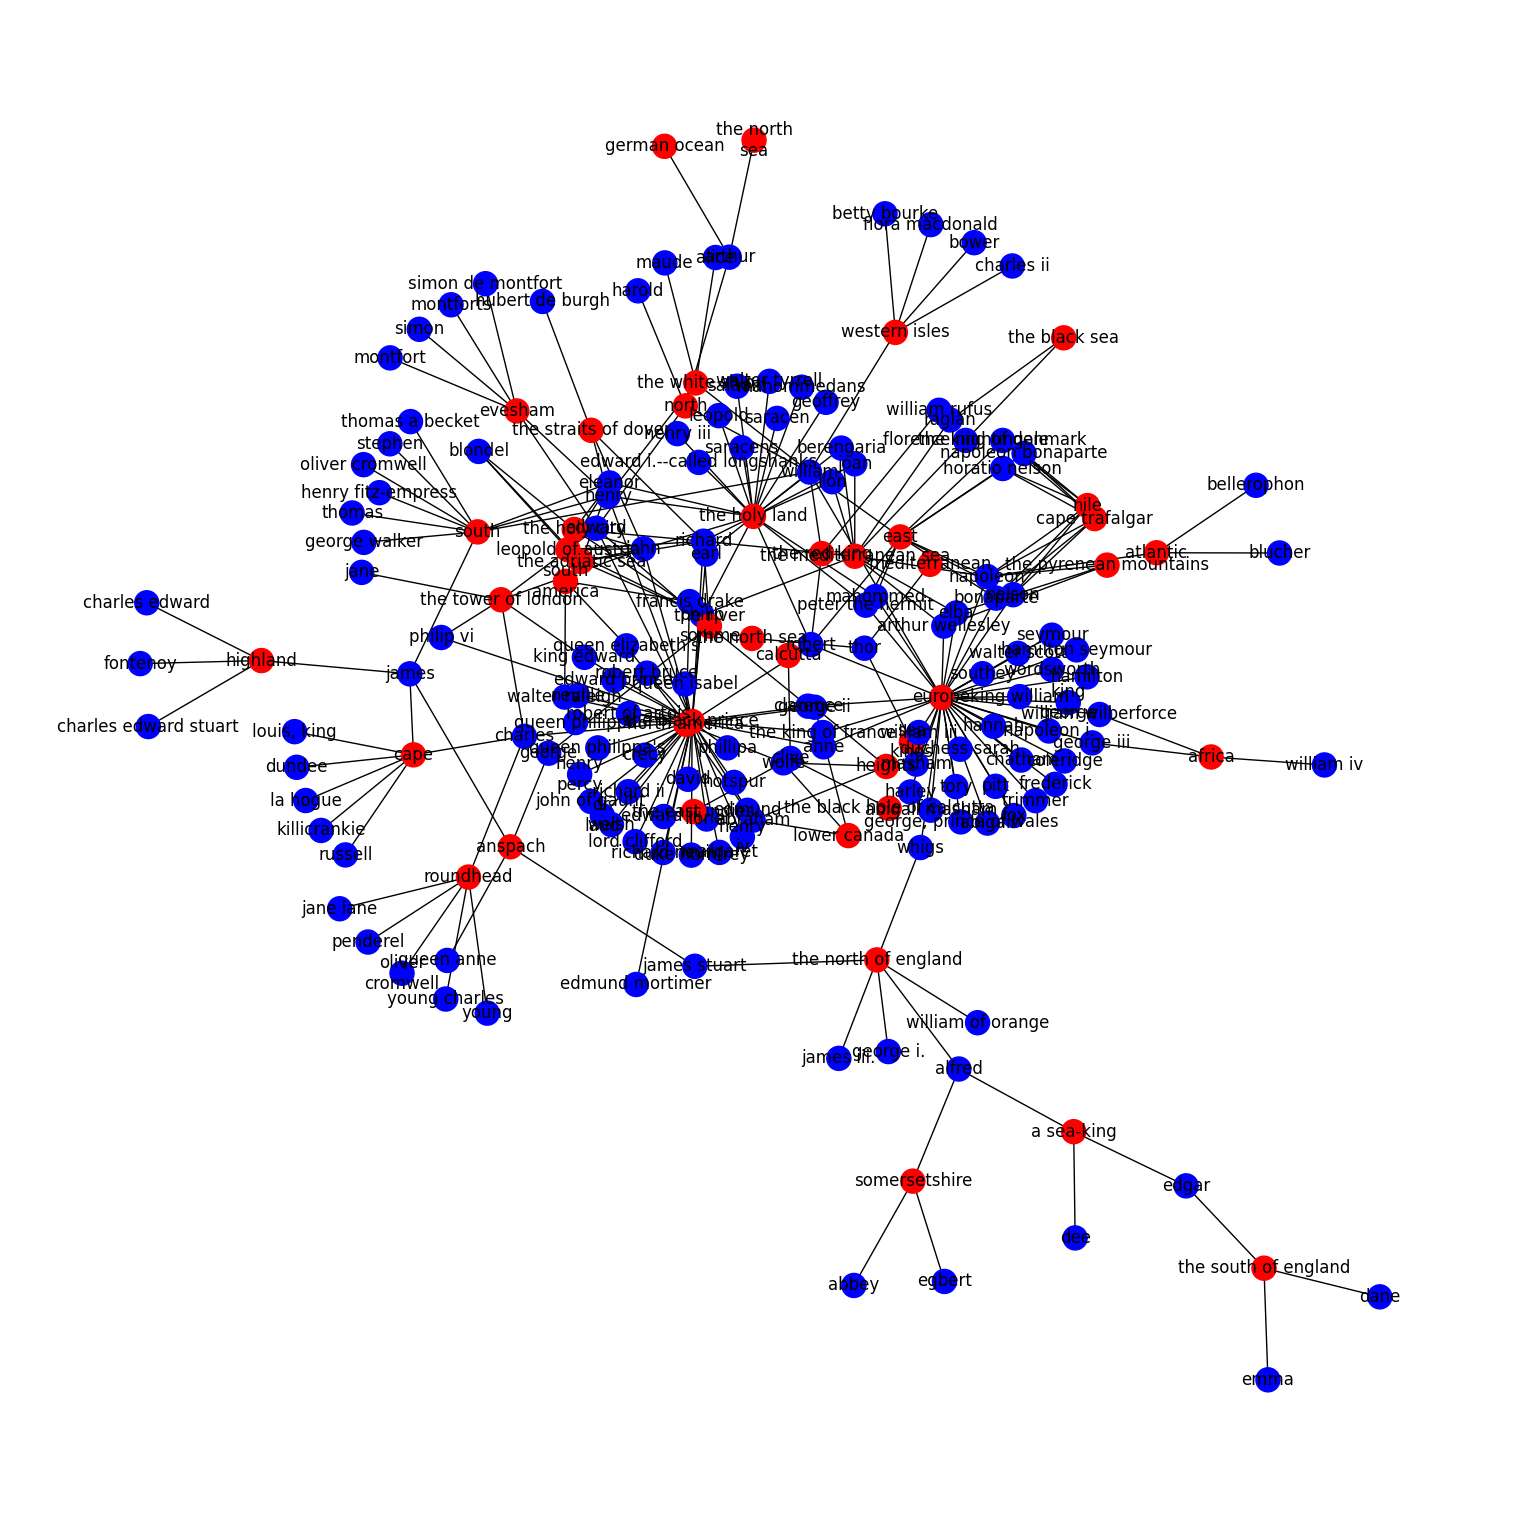

Ploting book 3:


100%|██████████| 2502/2502 [00:33<00:00, 75.39it/s]


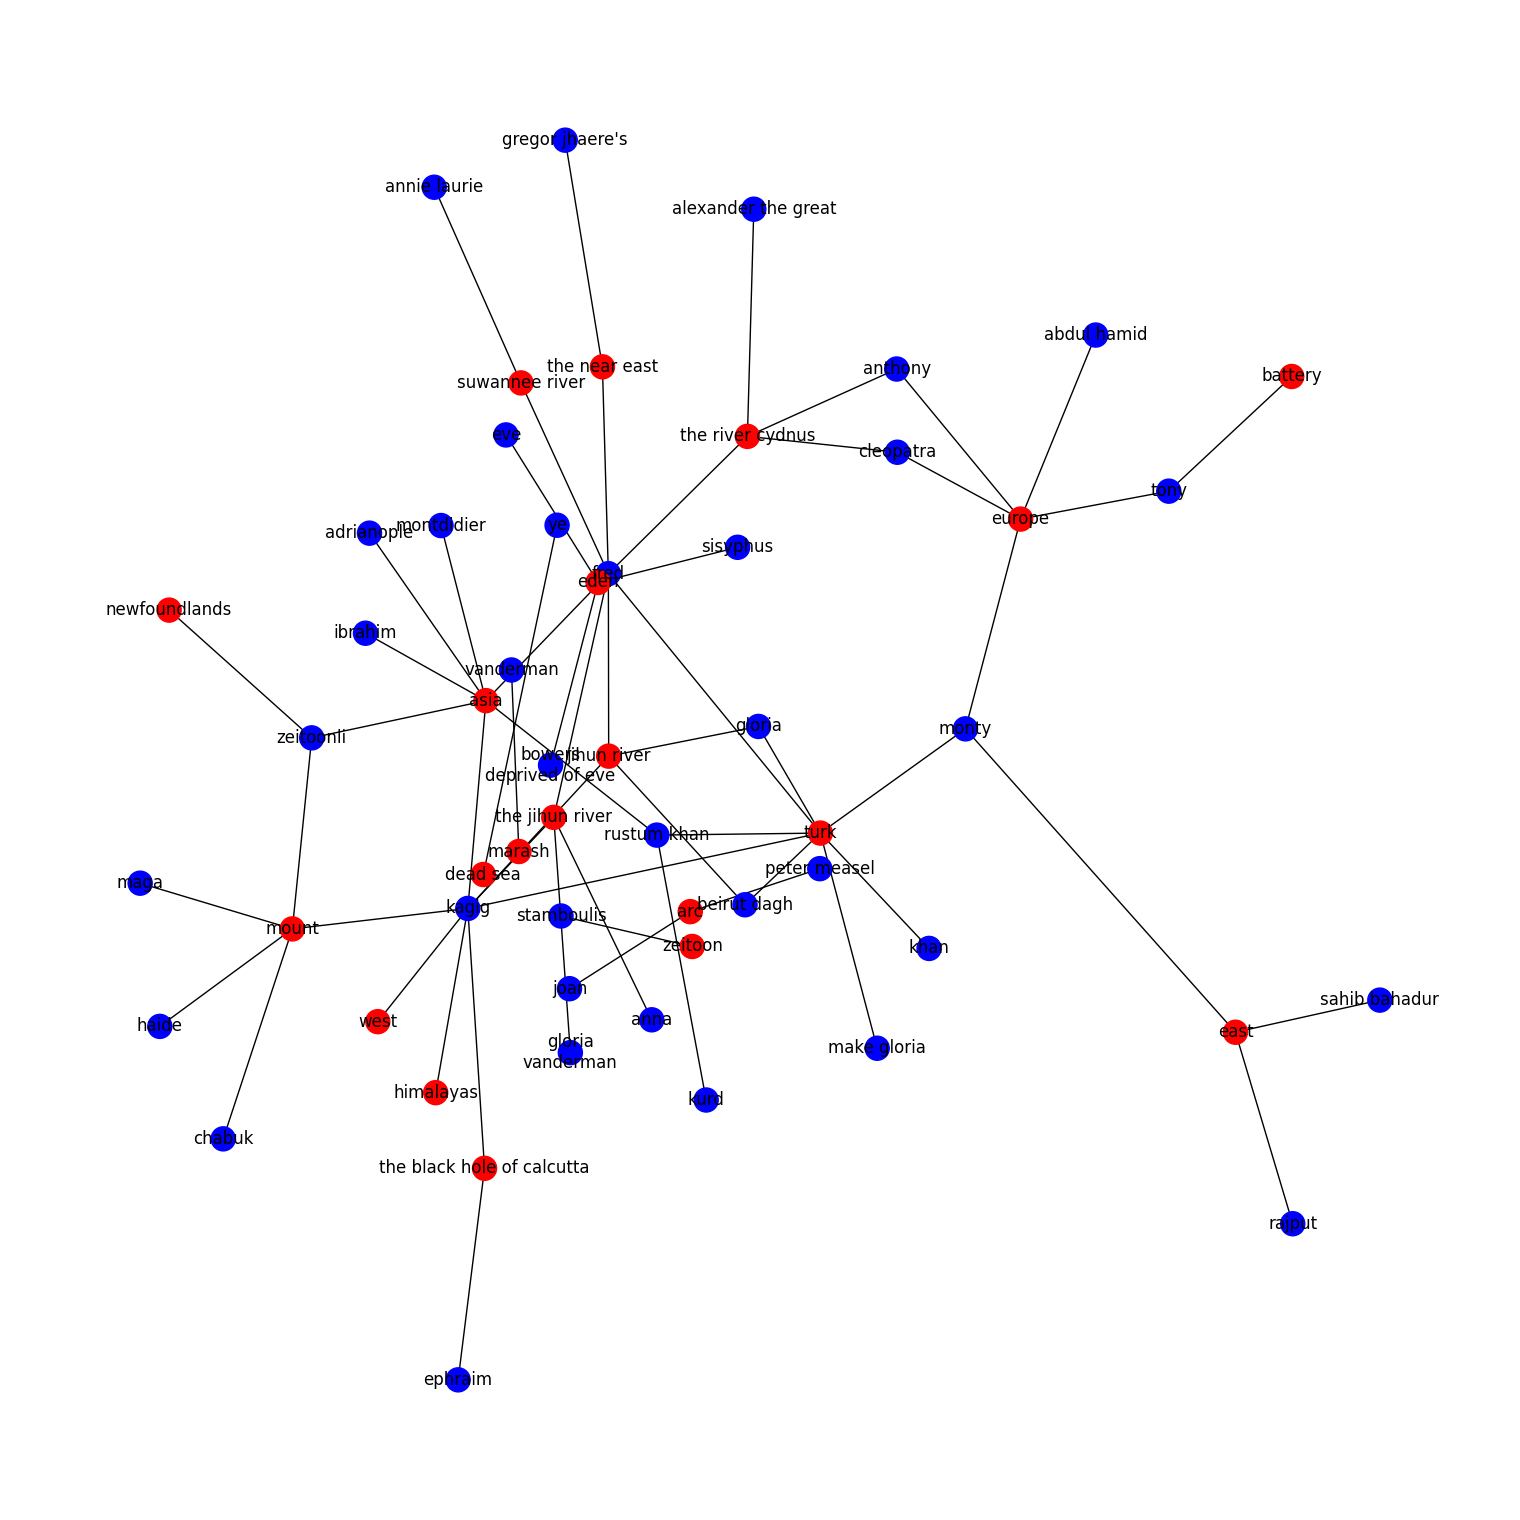

In [7]:
books = load_data()
question_1_by_idx(1, books[0])
question_1_by_idx(2, books[1])
question_1_by_idx(3, books[2])

**Question 2:** Use the [The Big Bang Theory Transcript](https://www.kaggle.com/datasets/mitramir5/the-big-bang-theory-series-transcript)
to create and evaluate a classifier that given a line of text can predict
 who said it (20pt). Using sentiment analysis identify who are the most and less friendly character(20pt). Construct a classifier that can be given several text lines (quotes) from a specific episode that will predict the episode's season number (20pt).

In [11]:
!mkdir ./datasets
!mkdir ./datasets/the-big-bang-theory-series-transcript

!kaggle datasets download mitramir5/the-big-bang-theory-series-transcript -p ./datasets/the-big-bang-theory-series-transcript
!unzip ./datasets/the-big-bang-theory-series-transcript/*.zip  -d ./datasets/the-big-bang-theory-series-transcript/

mkdir: cannot create directory ‘./datasets’: File exists
Dataset URL: https://www.kaggle.com/datasets/mitramir5/the-big-bang-theory-series-transcript
License(s): unknown
Archive:  ./datasets/the-big-bang-theory-series-transcript/the-big-bang-theory-series-transcript.zip
  inflating: ./datasets/the-big-bang-theory-series-transcript/1_10_seasons_tbbt.csv  
  inflating: ./datasets/the-big-bang-theory-series-transcript/sentences_sentiment_dicts.pkl  


In [12]:
!kaggle datasets download -d mitramir5/the-big-bang-theory-series-transcript
!unzip -o the-big-bang-theory-series-transcript.zip

Dataset URL: https://www.kaggle.com/datasets/mitramir5/the-big-bang-theory-series-transcript
License(s): unknown
Archive:  the-big-bang-theory-series-transcript.zip
  inflating: 1_10_seasons_tbbt.csv   
  inflating: sentences_sentiment_dicts.pkl  


In [13]:
df = pd.read_csv("1_10_seasons_tbbt.csv")
df = df.dropna()
df["season_label"] = df.episode_name.apply(lambda s: s.split(" ")[1])
df["episode_label"] = df.episode_name.apply(lambda s: s.split(" ")[3])
df.head()

,episode_name,dialogue,person_scene,season_label,episode_label
0,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Scene,01,01
1,Series 01 Episode 01 – Pilot Episode,So if a photon is directed through a plane wi...,Sheldon,01,01
2,Series 01 Episode 01 – Pilot Episode,"Agreed, what’s your point?",Leonard,01,01
3,Series 01 Episode 01 – Pilot Episode,"There’s no point, I just think it’s a good id...",Sheldon,01,01
4,Series 01 Episode 01 – Pilot Episode,Excuse me?,Leonard,01,01
...,...,...,...,...,...
54401,Series 10 Episode 24 – The Long Distance Disso...,"And I with you. Question, are you seeking a r...",Sheldon,10,24
54402,Series 10 Episode 24 – The Long Distance Disso...,What if I were?,Ramona,10,24
54403,Series 10 Episode 24 – The Long Distance Disso...,"Well, that would raise a number of problems. ...",Sheldon,10,24
54404,Series 10 Episode 24 – The Long Distance Disso...,Princeton.,Scene,10,24


In [20]:
vector_list = [
    nlp(dialogue).vector
    for dialogue in tqdm(df["dialogue"])
]
col_names = [f"Feature {i}" for i in range(len(vector_list[0]))]
df2 = pd.DataFrame(vector_list, columns=col_names)
df2['person_scene'] = df['person_scene'].to_numpy()

train, test = train_test_split(df2, test_size=TEST_RATIO, random_state=42)
X_train, X_test = train.drop('person_scene', axis=1), test.drop('person_scene', axis=1)
y_train, y_test = train['person_scene'], test['person_scene']
clf = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3)
clf.fit(X_train, y_train.to_numpy())
y_predict = clf.predict(X_test)
acc = accuracy_score(y_test,y_predict)
print(f"Accuracy of predicting who said the line is {acc}")

0:	learn: 4.3953855	total: 32.3s	remaining: 53m 20s
1:	learn: 3.7460177	total: 1m 4s	remaining: 52m 27s
2:	learn: 3.2687083	total: 1m 36s	remaining: 52m 15s
3:	learn: 3.1097027	total: 2m 9s	remaining: 51m 42s
4:	learn: 3.0123823	total: 2m 41s	remaining: 51m 4s
5:	learn: 2.9419628	total: 3m 13s	remaining: 50m 32s
6:	learn: 2.8878702	total: 3m 46s	remaining: 50m 7s
7:	learn: 2.8472918	total: 4m 18s	remaining: 49m 29s
8:	learn: 2.8141498	total: 4m 50s	remaining: 48m 59s
9:	learn: 2.7883189	total: 5m 23s	remaining: 48m 31s
10:	learn: 2.7624422	total: 5m 59s	remaining: 48m 28s
11:	learn: 2.7439643	total: 6m 31s	remaining: 47m 51s
12:	learn: 2.7241322	total: 7m 2s	remaining: 47m 10s
13:	learn: 2.7067565	total: 7m 34s	remaining: 46m 33s
14:	learn: 2.6894528	total: 8m 7s	remaining: 46m 2s
15:	learn: 2.6785493	total: 8m 37s	remaining: 45m 19s
16:	learn: 2.6651058	total: 9m 8s	remaining: 44m 37s
17:	learn: 2.6531324	total: 9m 40s	remaining: 44m 5s
18:	learn: 2.6299656	total: 10m 11s	remaining: 4

In [ ]:
afinn = Afinn()
df['dialogue_afinn'] = df['dialogue'].apply(lambda t: afinn.score(t))
mean_afinn_by_person_scene = df.groupby("person_scene")["dialogue_afinn"].mean().sort_values()
print(f"Top 10 less friendly character {mean_afinn_by_person_scene.head(10)}")
print(f"Top 10 most friendly character {mean_afinn_by_person_scene.tail(10).iloc[::-1]}")

Top 10 less friendly character person_scene
coat         -9.0
within)      -4.0
time)        -4.0
flat)        -4.0
Ricky)       -4.0
sleep)       -4.0
television   -3.5
Thor)        -3.0
spray)       -3.0
Leonard:     -3.0
Name: dialogue_afinn, dtype: float64

Top 10 most friendly character person_scene
box)            9.5
Flatow          9.0
brain)          9.0
talking)        8.0
rhinestones)    8.0
Jones           7.0
train)          7.0
Caller          7.0
alert)          7.0
nose)           7.0
Name: dialogue_afinn, dtype: float64



In [17]:
def predict_season_from_several_text_lines(vectors):
    vector = np.mean(vectors, axis=0)
    return clf.predict(vector)[0]

In [ ]:
df2['season_label'] = df['season_label'].to_numpy()
df2['episde_label'] = df['episode_label'].to_numpy()
df2 = df2.drop('person_scene', axis=1)
train, test = train_test_split(df2, test_size=0.2, random_state=42, stratify=df2['episde_label'])
X_train, X_test = train.drop(['episde_label', 'season_label'], axis=1), test.drop(['episde_label', 'season_label'], axis=1)
y_train, y_test = train['season_label'], test['season_label']
clf = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3)
clf.fit(X_train, y_train.to_numpy())

def predict_season_from_several_text_lines(group):  # noqa: F811
    vectors = group.iloc[:, :300].to_numpy() 
    vector = np.mean(vectors, axis=0)
    vector = vector.reshape(1, -1) 
    return clf.predict(vector)[0]

labels = []
predictions = []
for group_name, group in test.groupby(["episde_label", "season_label"]):
    try:
        labels.append(group_name[1])
        predictions.append(predict_season_from_several_text_lines(group))
    except Exception as e:
        print(f"Error processing group {group_name}: {e}")
        continue

acc = accuracy_score(labels,predictions)
print(f"Accuracy of predicting season from several text lines is {acc}")

0:	learn: 2.3012813	total: 455ms	remaining: 45.1s
1:	learn: 2.2997768	total: 885ms	remaining: 43.4s
2:	learn: 2.2983478	total: 1.34s	remaining: 43.2s
3:	learn: 2.2972921	total: 1.72s	remaining: 41.2s
4:	learn: 2.2960337	total: 2.05s	remaining: 39s
5:	learn: 2.2943032	total: 2.27s	remaining: 35.6s
6:	learn: 2.2933189	total: 2.55s	remaining: 33.9s
7:	learn: 2.2921958	total: 2.98s	remaining: 34.2s
8:	learn: 2.2912247	total: 3.49s	remaining: 35.3s
9:	learn: 2.2901728	total: 3.94s	remaining: 35.4s
10:	learn: 2.2889436	total: 4.37s	remaining: 35.4s
11:	learn: 2.2880055	total: 4.8s	remaining: 35.2s
12:	learn: 2.2871777	total: 5.22s	remaining: 35s
13:	learn: 2.2864268	total: 5.76s	remaining: 35.4s
14:	learn: 2.2854630	total: 6.37s	remaining: 36.1s
15:	learn: 2.2848765	total: 6.99s	remaining: 36.7s
16:	learn: 2.2842080	total: 7.41s	remaining: 36.2s
17:	learn: 2.2835083	total: 7.69s	remaining: 35.1s
18:	learn: 2.2826217	total: 7.97s	remaining: 34s
19:	learn: 2.2818869	total: 8.25s	remaining: 33s

**Question 3 (Bonus)**: Continue Example 7 in the lecture's notebook by using the headline categroy prediction to improve the fake news classifier (10pt).